In [96]:
import numpy as np
import matplotlib.pyplot as plt

In [171]:
# calibration_data = np.genfromtxt('keithley2000_10Vrange_ca_10Vrangeoutl.csv', delimiter=',')
no_res_data = np.genfromtxt('amplifier_cal_noresistor_10Vout_10Vin.csv', 
		delimiter=',')
res_data = np.genfromtxt('amplifier_cal_resistor_10Vout_10Vin.csv', 
		delimiter=',')

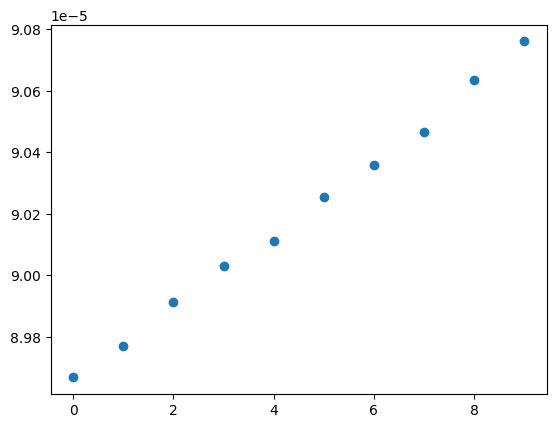

In [181]:
plt.plot(no_res_data[:, 0][:10] - no_res_data[:, 1][:10], 'o')

In [25]:
calibration_errors = np.std(calibration_data[:, 1].reshape(-1, 10), axis=-1, ddof=1)
calibration_dmm_volt = np.mean(calibration_data[:, 1].reshape(-1, 10), axis=-1)
calibration_ps_volt = np.mean(calibration_data[:, 0].reshape(-1, 10), axis=-1)

res_ps_volt = np.mean(res_data[:, 0].reshape(-1, 10), axis=-1)
res_dmm_volt = np.mean(res_data[:, 1].reshape(-1, 10), axis=-1)
res_errors = np.std(res_data[:, 1].reshape(-1, 10), axis=-1, ddof=1)

no_res_dmm_volt = np.mean(no_res_data[:, 1].reshape(-1, 10), axis=-1)
no_res_errors = np.std(no_res_data[:, 1].reshape(-1, 10), axis=-1, ddof=1)

calibration_ps_volt, res_ps_volt, res_errors, no_res_errors

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 array([3.08257577e-08, 8.39089454e-08, 5.79176619e-08, 6.84754620e-08,
        3.26598633e-08, 4.42216638e-08, 5.95911999e-08, 2.79880927e-08,
        1.20646407e-07, 4.28952212e-08, 8.83742044e-08, 6.05621811e-08,
        3.28125990e-08, 7.63398832e-08, 8.37721776e-08, 8.23340081e-08,
        1.40035710e-07, 5.58669054e-08, 2.66741656e-07, 9.08539731e-08]),
 array([3.62628413e-07, 9.15472556e-08, 5.52392775e-08, 5.34997404e-08,
        1.42906341e-07, 7.26941843e-08, 5.43752394e-08, 1.36284017e-07,
        7.73448267e-08, 9.89949494e-08, 5.75808609e-08, 1.22365572e-07,
        2.24254320e-07, 9.38142373e-08, 7.34922519e-08, 1.37780018e-07,
        5.97773647e-08, 1.37453022e-07, 2.42798499e-07, 2.23248740e-07]))

In [200]:
import scipy.optimize as opt

# errors for the Keithley 6487 in the 10V output range
def range_10_ps_errors(volt):
    return 0.1*volt/100 + 0.001

def linear_fit(x, *p):
    return p[0]*x + p[1]

calibration_ps_volt_err = range_10_ps_errors(calibration_ps_volt)

calibration_pars = opt.curve_fit(linear_fit, calibration_dmm_volt, calibration_ps_volt, p0=(1, 1e-3), 
    sigma = calibration_ps_volt_err,
    absolute_sigma=False)

m = calibration_pars[0][0]
sigma_m = np.sqrt(calibration_pars[1][0, 0])

b = calibration_pars[0][1]
sigma_b = np.sqrt(calibration_pars[1][1, 1])

sigma_mb = calibration_pars[1][1, 0]

def v_error(V):
    return np.sqrt(sigma_m*sigma_m*V*V + sigma_b*sigma_b + 2*sigma_mb*V)

def v_cal(V):
    return m*V + b

calibration_pars, sigma_m, sigma_b, m, b, sigma_mb

((array([1.00005267e+00, 5.67199656e-05]),
  array([[ 8.18678343e-11, -9.90572724e-11],
         [-9.90572724e-11,  4.03965145e-10]])),
 9.04808456791418e-06,
 2.009888417611065e-05,
 1.0000526733556048,
 5.6719965596231896e-05,
 -9.90572724188769e-11)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

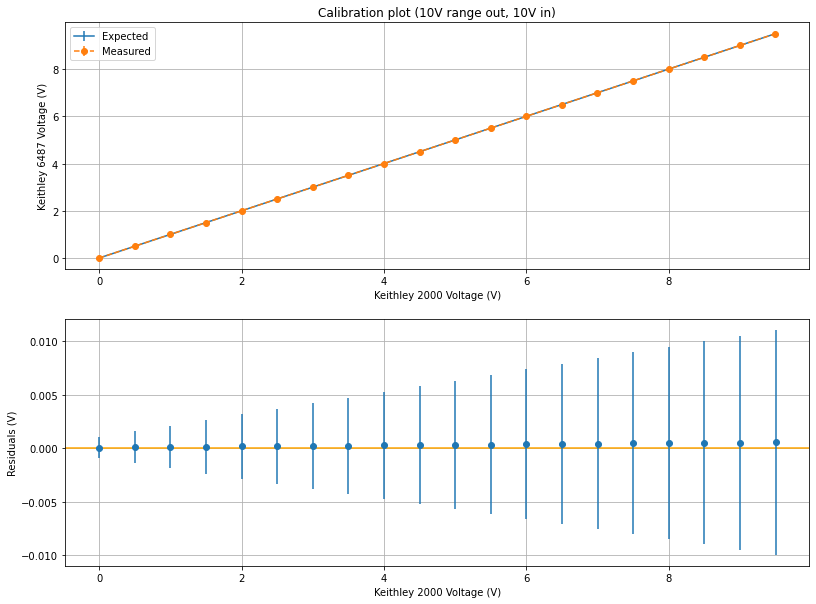

In [210]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13.33333, 10]

volts = np.arange(0.0, 10, 0.5)
v_exp = v_cal(volts)
exp_err = v_error(volts)

plt.subplot(2, 1, 1)
plt.errorbar(volts, v_exp, yerr=exp_err, label="Expected")
plt.errorbar(calibration_dmm_volt, calibration_ps_volt, fmt="--o", yerr=calibration_ps_volt_err, label="Measured")
plt.xlabel("Keithley 2000 Voltage (V)")
plt.ylabel("Keithley 6487 Voltage (V)")
plt.title("Calibration plot (10V range out, 10V in)")
plt.grid(True)
plt.legend()

residual_errors = np.sqrt(exp_err**2 + calibration_ps_volt_err**2)
plt.subplot(2, 1, 2)
plt.axhline(y=0, color="orange")
plt.errorbar(volts, v_exp - calibration_ps_volt, yerr=residual_errors, fmt='o', label="Expected")
plt.grid(True)
plt.xlabel("Keithley 2000 Voltage (V)")
plt.ylabel("Residuals (V)")

volts

In [211]:
gamma = 3.26363048
gamma_var = 5.64774292e-11
gamma_std = np.sqrt(gamma_var)

gamma_std

7.5151466519290225e-06

In [223]:
R_l = 100e3
Ramp = R_l*m/gamma
Ramp_std = Ramp*np.sqrt((0.02/100)**2 + (sigma_m/m)**2 + (gamma_std/gamma)**2)

Ramp, Ramp_std

(30642.33771206858, 6.135140998164022)

## Keithley 100V range calibration using a Keithley 6487 500V range calibrated power supply

In [4]:
voltage_cal_data = np.genfromtxt('keithley2000_100Vrange_cal_500Vrangeout.csv', delimiter=',')

In [23]:
measured_voltages = voltage_cal_data[:, 1].reshape(-1, 10) # Keithley 2000
supply_voltages = voltage_cal_data[:, 0].reshape(-1, 10) # Keithley 6487

In [26]:
u_measured_voltages = np.mean(measured_voltages, axis=-1)
u_supply_voltages = np.mean(supply_voltages, axis=-1)

In [37]:
err_supply_voltages = np.power(u_supply_voltages*(0.15/100) + 40e-3, 2) / 3

In [153]:
err_measured_voltages = np.var(measured_voltages, axis=-1, ddof=1) / 10

np.sqrt(err_measured_voltages)

array([1.10701709e-05, 1.99477889e-05, 2.03758523e-05, 1.78189846e-05,
       9.29105712e-06, 1.35967217e-05, 1.17557513e-05, 1.53404905e-05,
       1.92606076e-05, 1.71957630e-05, 1.15240565e-05, 1.91527338e-05,
       1.68234232e-05, 1.91344587e-05, 2.04759992e-05, 1.61571945e-05,
       1.13008952e-05, 1.22876365e-05, 1.71942397e-05, 1.42864053e-05,
       3.09160600e-05, 1.29209051e-05, 1.21010009e-05, 1.10727538e-05,
       1.68798117e-05, 1.58046041e-05, 8.73284986e-06, 3.24858232e-05,
       1.25833152e-05, 1.54015371e-05, 1.95041033e-05, 2.30261023e-05,
       1.80118097e-05, 1.29511372e-05, 2.85246552e-05, 2.01804099e-05,
       1.37595930e-05, 9.58729541e-06, 2.08328771e-05, 2.53491223e-05,
       1.64156704e-05, 2.08830152e-05, 1.22247999e-05, 2.03974072e-05,
       1.67095678e-05, 2.31925297e-05, 1.05404665e-05, 1.91891868e-05,
       9.74336013e-06, 1.20933411e-05, 2.10902621e-05, 1.63648909e-05,
       9.93854226e-06, 1.98420880e-05, 8.19718109e-06, 2.40523956e-05,
      

In [132]:
import statsmodels.api as sm

In [65]:
X = sm.add_constant(u_measured_voltages)
out = sm.WLS(u_supply_voltages, X, weights=1.0/err_supply_voltages)
res_out = out.fit()

In [66]:
print(res_out.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.402e+09
Date:                Tue, 04 Apr 2023   Prob (F-statistic):          7.92e-216
Time:                        12:14:31   Log-Likelihood:                 252.46
No. Observations:                  60   AIC:                            -500.9
Df Residuals:                      58   BIC:                            -496.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.100      0.2

In [81]:
bp, mp = res_out.params
cov = res_out.cov_params()
res_out.params, res_out.cov_params()

(array([7.05530249e-04, 9.99980738e-01]),
 array([[ 4.11652105e-07, -1.29231712e-08],
        [-1.29231712e-08,  7.13036209e-10]]))

In [ ]:
y = m*x + b

1/m(y - b) = 1/m(y - b) = m'y + b'
m' = 1/m
b' = -b/m

sm'^2 = sm^2 (1/m^2)^2
sb'^2 = sb^2 (1/m)^2 + sm^2(b/m^2)^2 + 2*sbm*(-1/m)*(b/m^2)

In [138]:
b = -bp / mp
m = 1/mp

sm = cov[1, 1] * (1/mp**2)**2
sb = cov[0, 0] * (1/mp)**2 + cov[1, 1] * (bp / mp**2)**2 - 2*cov[1,0]*(bp/mp**3)

std_m = np.sqrt(sm)
std_b = np.sqrt(sb)

In [130]:
m, np.sqrt(sm), sm, bp, np.sqrt(sb), sb

(1.0000192626390627,
 2.670376658717859e-05,
 7.130911499425157e-10,
 0.0007055302493056415,
 0.0006416277747819904,
 4.116862013716885e-07)

Text(0, 0.5, 'Residuals (V)')

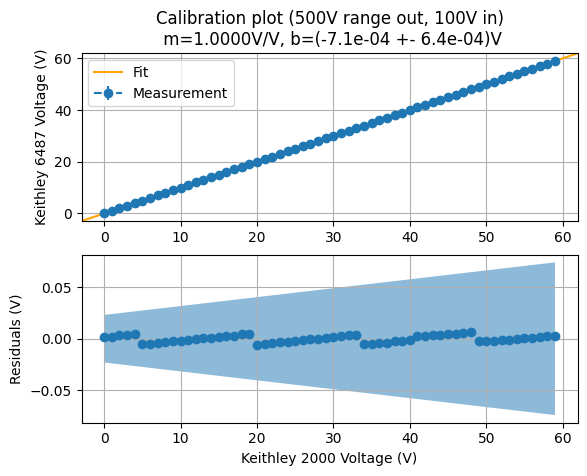

In [182]:
plt.subplot(2, 1, 1)

plt.errorbar(u_measured_voltages, u_supply_voltages, yerr=np.sqrt(err_supply_voltages), fmt="--o", label="Measurement")
plt.axline((0, b), color='orange', slope=m, label='Fit')
# plt.xlabel("Keithley 2000 Voltage (V)")
plt.ylabel("Keithley 6487 Voltage (V)")
plt.title(f"Calibration plot (500V range out, 100V in)\n m={m:.4f}V/V, b=({b:.1e} +- {std_b:.1e})V")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)

res_sys = np.sqrt(err_supply_voltages)
res_error = np.sqrt(cov[1, 1]*u_measured_voltages**2 + cov[0,0])
plt.errorbar(u_measured_voltages, u_supply_voltages - (mp*u_measured_voltages + bp), fmt='o', yerr=res_error)
plt.fill_between(u_measured_voltages,- res_sys,
                  + res_sys, alpha=0.5)
plt.grid(True)
plt.xlabel("Keithley 2000 Voltage (V)")
plt.ylabel("Residuals (V)")